# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [12]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [14]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [202]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))



(1,)
(1,)
Gradient check passed!
(2,)
(2,)
Gradient check passed!
(2, 2)
(2, 2)
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [186]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [187]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
print(probs)
linear_classifer.cross_entropy_loss(probs, 1)

[4.50940412e-05 6.69254912e-03 9.93262357e-01]


5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [205]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

(3,)
(3,)
Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [279]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

(1, 4)
(1, 4)
Gradients are SAME at (0, 0). Analytic: 0.20603, Numeric: 0.20603
Gradients are SAME at (0, 1). Analytic: 0.56005, Numeric: 0.56005
Gradients are SAME at (0, 2). Analytic: -0.97212, Numeric: -0.97212
Gradients are SAME at (0, 3). Analytic: 0.20603, Numeric: 0.20603
Gradient check passed!
(3, 4)
(3, 4)
Gradients are SAME at (0, 0). Analytic: 0.22715, Numeric: 0.22715
Gradients are SAME at (0, 1). Analytic: 0.01131, Numeric: 0.01131
Gradients are SAME at (0, 2). Analytic: 0.01131, Numeric: 0.01131
Gradients are SAME at (0, 3). Analytic: -0.24977, Numeric: -0.24977
Gradients are SAME at (1, 0). Analytic: 0.03641, Numeric: 0.03641
Gradients are SAME at (1, 1). Analytic: 0.09897, Numeric: 0.09897
Gradients are SAME at (1, 2). Analytic: 0.09897, Numeric: 0.09897
Gradients are SAME at (1, 3). Analytic: -0.23436, Numeric: -0.23436
Gradients are SAME at (2, 0). Analytic: 0.05072, Numeric: 0.05072
Gradients are SAME at (2, 1). Analytic: 0.13787, Numeric: 0.13787
Gradients are SAME 

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [278]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

(3, 2)
(3, 2)
Gradients are SAME at (0, 0). Analytic: -0.44040, Numeric: -0.44040
Gradients are SAME at (0, 1). Analytic: 0.44040, Numeric: 0.44040
Gradients are SAME at (1, 0). Analytic: -0.41669, Numeric: -0.41669
Gradients are SAME at (1, 1). Analytic: 0.41669, Numeric: 0.41669
Gradients are SAME at (2, 0). Analytic: 0.46411, Numeric: 0.46411
Gradients are SAME at (2, 1). Analytic: -0.46411, Numeric: -0.46411
Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [277]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

(3, 2)
(3, 2)
Gradients are SAME at (0, 0). Analytic: 0.02000, Numeric: 0.02000
Gradients are SAME at (0, 1). Analytic: 0.04000, Numeric: 0.04000
Gradients are SAME at (1, 0). Analytic: -0.02000, Numeric: -0.02000
Gradients are SAME at (1, 1). Analytic: 0.02000, Numeric: 0.02000
Gradients are SAME at (2, 0). Analytic: 0.02000, Numeric: 0.02000
Gradients are SAME at (2, 1). Analytic: 0.04000, Numeric: 0.04000
Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [285]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e-4)

Epoch 0, loss: 2.301406
Epoch 1, loss: 2.300645
Epoch 2, loss: 2.301930
Epoch 3, loss: 2.300194
Epoch 4, loss: 2.296883
Epoch 5, loss: 2.297291
Epoch 6, loss: 2.293188
Epoch 7, loss: 2.297095
Epoch 8, loss: 2.290985
Epoch 9, loss: 2.289429


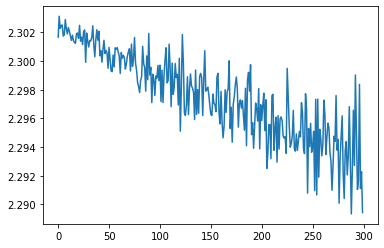

In [297]:
# let's look at the loss history!
plt.plot(loss_history)

In [295]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-1, batch_size=300, reg=1e-4)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.243
Epoch 0, loss: 2.103679
Epoch 1, loss: 2.153904
Epoch 2, loss: 2.125957
Epoch 3, loss: 2.120457
Epoch 4, loss: 2.120261
Epoch 5, loss: 2.113407
Epoch 6, loss: 2.233294
Epoch 7, loss: 2.106072
Epoch 8, loss: 2.141549
Epoch 9, loss: 2.148624
Epoch 10, loss: 2.116341
Epoch 11, loss: 2.127162
Epoch 12, loss: 2.055827
Epoch 13, loss: 2.119430
Epoch 14, loss: 2.108251
Epoch 15, loss: 2.060418
Epoch 16, loss: 2.118616
Epoch 17, loss: 2.143637
Epoch 18, loss: 2.061261
Epoch 19, loss: 2.120952
Epoch 20, loss: 2.096754
Epoch 21, loss: 2.102424
Epoch 22, loss: 2.185585
Epoch 23, loss: 2.059532
Epoch 24, loss: 2.095658
Epoch 25, loss: 2.062088
Epoch 26, loss: 2.103681
Epoch 27, loss: 2.056228
Epoch 28, loss: 2.085164
Epoch 29, loss: 2.113842
Epoch 30, loss: 2.078201
Epoch 31, loss: 2.086406
Epoch 32, loss: 2.086290
Epoch 33, loss: 2.075500
Epoch 34, loss: 2.092268
Epoch 35, loss: 2.041916
Epoch 36, loss: 2.143959
Epoch 37, loss: 2.037993
Epoch 38, loss: 2.130806
Epoch 39, loss: 1.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [ ]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially


print('best validation accuracy achieved: %f' % best_val_accuracy)

# Какой же точности мы добились на тестовых данных?

In [296]:
test_pred = classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.215000


## Experiments

In [ ]:
A = np.array([[10,20,30,40],[1,2,3,4]])

In [ ]:
it = np.nditer(A, flags=['multi_index'], op_flags=['readwrite'])
while not it.finished:
    ix = it.multi_index
    print(ix)
    it.iternext()

In [100]:
linear_classifer.softmax(A)

array([[9.35719813e-14, 2.06106005e-09, 4.53978686e-05, 9.99954600e-01],
       [3.20586033e-02, 8.71443187e-02, 2.36882818e-01, 6.43914260e-01]])

In [101]:
linear_classifer.softmax(A[1])

array([0.0320586 , 0.08714432, 0.23688282, 0.64391426])

In [102]:
A - np.max(A, axis=1)[:,np.newaxis]

array([[-30, -20, -10,   0],
       [ -3,  -2,  -1,   0]])

In [30]:
A[1].dim, A.shape

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [45]:
t = np.array([[0,0,0,1],[0,1,0,0] ])
t.T

array([[0, 0],
       [0, 1],
       [0, 0],
       [1, 0]])

In [47]:
B.dot(t.T)

array([[9.99954600e-01, 2.06106005e-09],
       [6.43914260e-01, 8.71443187e-02]])

In [49]:
np.multiply(B, t)

array([[0.        , 0.        , 0.        , 0.9999546 ],
       [0.        , 0.08714432, 0.        , 0.        ]])

In [59]:
Z = np.zeros_like(B)
Z

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [62]:
b=np.array([1])

Z[np.arange(len(b)), b]=1
Z


array([[0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [73]:
np.min(A[1], axis=-1)

-3

In [76]:

A -= np.max(A, axis=-1)[:,np.newaxis]
A/np.sum(A, axis=-1)[:,None]

array([[ 0.5       ,  0.33333333,  0.16666667, -0.        ],
       [ 0.5       ,  0.33333333,  0.16666667, -0.        ]])

In [88]:
np.squeeze(np.array([1,2,3,4])[np.newaxis,:])

array([1, 2, 3, 4])

In [89]:
np.squeeze(Z)

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [121]:
probs = linear_classifer.softmax(np.array([[55, 0, 45], [33,3,4]]))
target_index = [0,0]
px = np.zeros_like(probs)
if len(px.shape) == 1:
    px[target_index] = 1
else:
    px[np.arange(px.shape[0]), target_index] = 1

- np.sum(np.multiply(np.log(probs), px))

4.5398899564764524e-05

In [110]:
px

array([0., 1., 0.])

In [111]:
probs

array([4.50940412e-05, 6.69254912e-03, 9.93262357e-01])

In [112]:
np.multiply(probs, px)

array([0.        , 0.00669255, 0.        ])

In [141]:
linear_classifer.softmax_with_cross_entropy(np.array(B), [1,0])

(3.3783295551500574,
 array([[ 0.17488009, -0.82511991,  0.17488803,  0.47535179],
        [-0.80498422,  0.20605975,  0.23934468,  0.3595798 ]]))

In [146]:
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, [1,0]), B)

[[9.35719813e-14 2.06106005e-09 4.53978686e-05 9.99954600e-01]
 [3.20586033e-02 8.71443187e-02 2.36882818e-01 6.43914260e-01]]
[[9.35719813e-14 2.06106005e-09 4.53978686e-05 9.99954600e-01]
 [3.20586033e-02 8.71443187e-02 2.36882818e-01 6.43914260e-01]]
Gradient check passed!


True

In [147]:
B

array([[-9.99999991e-06, -9.99793894e-06,  3.53978686e-05,
         9.99944600e-01],
       [ 3.20486033e-02,  8.71343187e-02,  2.36872818e-01,
         6.43904260e-01]])

In [159]:
np.random.randint(-1, 3, size=(batch_size, num_classes))

array([[ 0, -1,  0,  2],
       [ 2,  0,  0,  0],
       [ 2,  2, -1, -1]])

In [167]:
A

array([[-30, -20, -10,   0],
       [ -3,  -2,  -1,   0]])

In [242]:
A = np.array([[-30, -20, -10,   0],
       [ -3,  -2,  -1,   0],
       [ 3,  2,  1,   0]])

target_index = [1,1,0]

probs = linear_classifer.softmax(A)
print(probs)
loss = linear_classifer.cross_entropy_loss(probs,target_index)
print(loss)


px = np.zeros_like(probs)
if len(px.shape) == 1:
    px[target_index] = 1
else:
    px[np.arange(px.shape[0]), target_index] = 1

print(px)

dprediction = np.multiply(-(1-probs),px)
print(dprediction)


[[9.35719813e-14 2.06106005e-09 4.53978686e-05 9.99954600e-01]
 [3.20586033e-02 8.71443187e-02 2.36882818e-01 6.43914260e-01]
 [6.43914260e-01 2.36882818e-01 8.71443187e-02 3.20586033e-02]]


AttributeError: 'list' object has no attribute 'flatten'

In [241]:
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), A.astype(np.float))


(3, 4)
(3, 4)
Gradients are SAME at (0, 0). Analytic: -1.00000, Numeric: -1.00000
Gradients are SAME at (0, 1). Analytic: 0.00000, Numeric: 0.00000
Gradients are SAME at (0, 2). Analytic: 0.00005, Numeric: 0.00005
Gradients are SAME at (0, 3). Analytic: 0.99995, Numeric: 0.99995
Gradients are SAME at (1, 0). Analytic: -0.96794, Numeric: -0.96794
Gradients are SAME at (1, 1). Analytic: 0.08714, Numeric: 0.08714
Gradients are SAME at (1, 2). Analytic: 0.23688, Numeric: 0.23688
Gradients are SAME at (1, 3). Analytic: 0.64391, Numeric: 0.64392
Gradients are SAME at (2, 0). Analytic: 0.64391, Numeric: 0.64391
Gradients are SAME at (2, 1). Analytic: 0.23688, Numeric: 0.23688
Gradients are SAME at (2, 2). Analytic: -0.91286, Numeric: -0.91285
Gradients are SAME at (2, 3). Analytic: 0.03206, Numeric: 0.03206
Gradient check passed!


True

In [240]:
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index[1]), A[1].astype(np.float))

(4,)
(4,)
Gradients are SAME at (0,). Analytic: -0.96794, Numeric: -0.96794
Gradients are SAME at (1,). Analytic: 0.08714, Numeric: 0.08714
Gradients are SAME at (2,). Analytic: 0.23688, Numeric: 0.23688
Gradients are SAME at (3,). Analytic: 0.64391, Numeric: 0.64392
Gradient check passed!


True

In [239]:
# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
print(target_index)

target_index
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)


[[0]
 [0]
 [2]]
(3, 4)
(3, 4)
Gradients are SAME at (0, 0). Analytic: -0.80339, Numeric: -0.80339
Gradients are SAME at (0, 1). Analytic: 0.07233, Numeric: 0.07233
Gradients are SAME at (0, 2). Analytic: 0.19661, Numeric: 0.19661
Gradients are SAME at (0, 3). Analytic: 0.53445, Numeric: 0.53445
Gradients are SAME at (1, 0). Analytic: -0.84784, Numeric: -0.84784
Gradients are SAME at (1, 1). Analytic: 0.41362, Numeric: 0.41362
Gradients are SAME at (1, 2). Analytic: 0.41362, Numeric: 0.41362
Gradients are SAME at (1, 3). Analytic: 0.02059, Numeric: 0.02059
Gradients are SAME at (2, 0). Analytic: 0.31895, Numeric: 0.31895
Gradients are SAME at (2, 1). Analytic: 0.04316, Numeric: 0.04316
Gradients are SAME at (2, 2). Analytic: -0.68105, Numeric: -0.68105
Gradients are SAME at (2, 3). Analytic: 0.31895, Numeric: 0.31895
Gradient check passed!


True

In [238]:
target_index.flatten()

array([2, 1, 1])

In [272]:
A

array([[-30, -20, -10,   0],
       [ -3,  -2,  -1,   0],
       [  3,   2,   1,   0]])

In [274]:
np.argmax(A, axis=1)

array([3, 3, 0])